# Test validity partial step 4 : $P(B_f | ...) \propto -(d - B_c s_c)^t N^{-1} B_f (B_f^t N^{-1} B_f)^{-1} B_f^t N^{-1} (d-B_c s_c)$

In [1]:
import os, sys
import numpy as np
import matplotlib.pyplot as plt
import scipy
import healpy as hp
import astropy.io.fits as fits
import camb
import emcee
import jax
import jax.numpy as jnp
import jax.scipy as jsp
import jax_healpy as jhp
import numpyro
from functools import partial
import micmac as micmac
# from mcmc_tools import *

from jax import config
config.update("jax_enable_x64", True)

/Users/mag/miniconda3/envs/non_param_silver/lib/python3.9/site-packages/jax/_src/api_util.py:229: SyntaxWarning: Jitted function has invalid argnames {'regularization_factor'} in static_argnames. Function does not take these args.This warning will be replaced by an error after 2022-08-20 at the earliest.
  warnings.warn(f"Jitted function has invalid argnames {invalid_argnames} "


In [2]:
sys.path.append(os.path.dirname(os.path.abspath('')))
sys.path.append(os.path.dirname(os.path.dirname(os.path.abspath('')))+'/tutorials/')
from func_tools_for_tests import *
from get_freq_maps_SO_64 import *
# from get_freq_maps_LiteBIRD_64 import *
# freq_maps is defined there

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


(6, 2, 49152)
(6, 2, 49152)


In [3]:
instrument

,frequency,depth_p,depth_i,fwhm,f_sky,status,reference,type,note,experiment
0,27.0,49.5,35.0,91.0,0.1,forecast,Journal of Cosmology and Astroparticle Physics...,ground,depth_p is simply depth_i * sqrt(2),SO_SAT
1,39.0,29.7,21.0,63.0,0.1,forecast,Journal of Cosmology and Astroparticle Physics...,ground,depth_p is simply depth_i * sqrt(2),SO_SAT
2,93.0,3.7,2.6,30.0,0.1,forecast,Journal of Cosmology and Astroparticle Physics...,ground,depth_p is simply depth_i * sqrt(2),SO_SAT
3,145.0,4.7,3.3,17.0,0.1,forecast,Journal of Cosmology and Astroparticle Physics...,ground,depth_p is simply depth_i * sqrt(2),SO_SAT
4,225.0,8.9,6.3,11.0,0.1,forecast,Journal of Cosmology and Astroparticle Physics...,ground,depth_p is simply depth_i * sqrt(2),SO_SAT
5,280.0,22.6,16.0,9.0,0.1,forecast,Journal of Cosmology and Astroparticle Physics...,ground,depth_p is simply depth_i * sqrt(2),SO_SAT


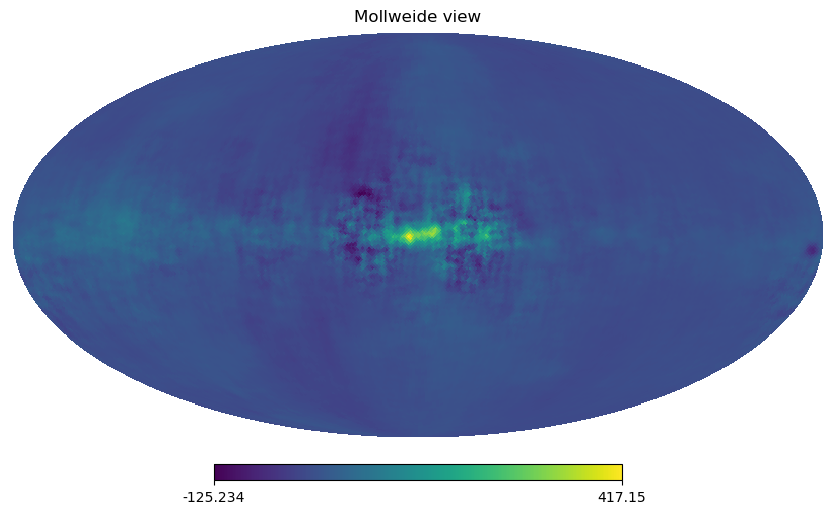

In [4]:
hp.mollview(freq_maps[0,0]) # Freq, nstokes, npix

In [5]:
nstokes = 2
nside = 64
lmax = nside*2
lmin = 2

number_frequencies = freq_maps.shape[0]
number_components = 3

limit_iter_cg=2000
tolerance_CG=10**(-12)

n_iter = 8

number_correlations = int(np.ceil(nstokes**2/2) + np.floor(nstokes/2))

param_dict = {'nside':nside, 'lmax':lmax, 'nstokes':nstokes, 'number_correlations':number_correlations,'number_frequencies':number_frequencies, 'number_components':number_components}
npix = 12*nside**2

In [6]:
all_spectra = generate_power_spectra_CAMB(nside*2, typeless_bool=True)
lensing_spectra = all_spectra['lensed_scalar'][:lmax+1,:]
camb_cls = all_spectra['total'][:lmax+1,:]

c_ells_input = np.zeros((6,lmax+1))
c_ells_input[:4,...] = camb_cls.T
c_ell_approx = np.zeros((6,lmax+1))
c_ell_approx[1] = camb_cls.T[1]
c_ell_approx[2] = lensing_spectra.T[2]


Calculating spectra from CAMB !


In [7]:
indices_polar = np.array([1,2,4])

if nstokes == 2:    
    c_ells_input = c_ells_input[indices_polar,:]
    c_ell_approx = c_ell_approx[indices_polar,:]
    # CMB_map_input = CMB_map_input[1:,:]
    # freq_maps = freq_maps[:,1:,:]

# CMB covariance preparation
red_cov_approx_matrix = micmac.get_reduced_matrix_from_c_ell(c_ell_approx)[lmin:,...]
red_cov_matrix = micmac.get_reduced_matrix_from_c_ell(c_ells_input)[lmin:,...]

# Mixing matrix initialization
init_mixing_matrix_obj = micmac.InitMixingMatrix(np.array(instrument['frequency']), number_components, pos_special_freqs=[-1,0])
init_params = init_mixing_matrix_obj.init_params()

mixing_matrix_obj = micmac.MixingMatrix(instrument['frequency'], number_components, init_params, pos_special_freqs=[-1,0])
# mixing_matrix_obj.update_params(mixing_matrix_obj.params/100)
mixing_matrix_sampled = mixing_matrix_obj.get_B()


# Noise initialization
depth_p = instrument['depth_p']
freq_inverse_noise = micmac.get_noise_covar(depth_p, nside)
cp_cp_noise = micmac.get_inv_BtinvNB(freq_inverse_noise, mixing_matrix_sampled)
cp_freq_inv_noise_sqrt = micmac.get_BtinvN(scipy.linalg.sqrtm(freq_inverse_noise), mixing_matrix_sampled)
cp_freq_inv_noise = micmac.get_BtinvN(freq_inverse_noise, mixing_matrix_sampled)

In [8]:
init_params.shape

(4, 2)

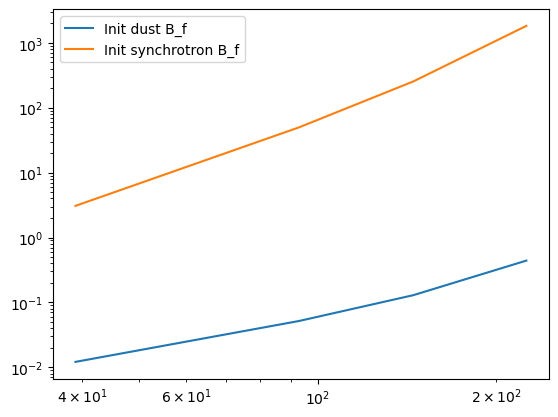

In [9]:
frequency_Bf = instrument['frequency'][1:-1]

plt.plot(frequency_Bf, init_params[:,0], label='Init dust B_f')
plt.plot(frequency_Bf, init_params[:,1], label='Init synchrotron B_f')
plt.legend()
plt.loglog()
plt.show()

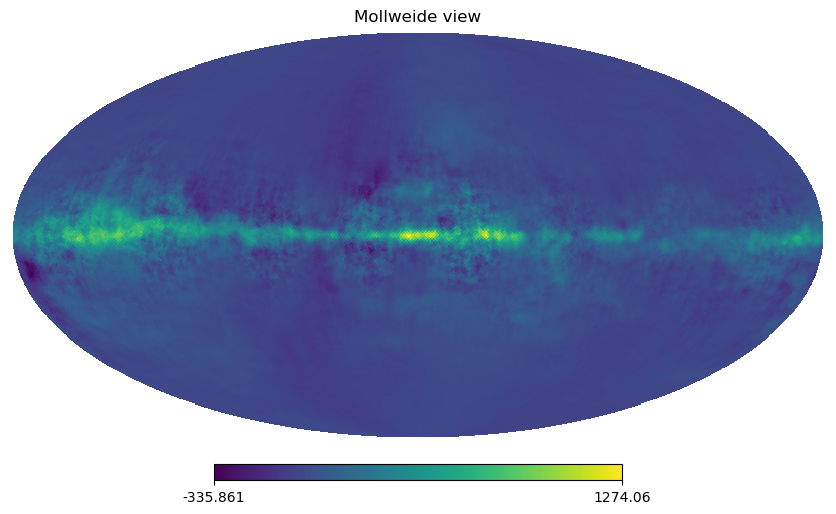

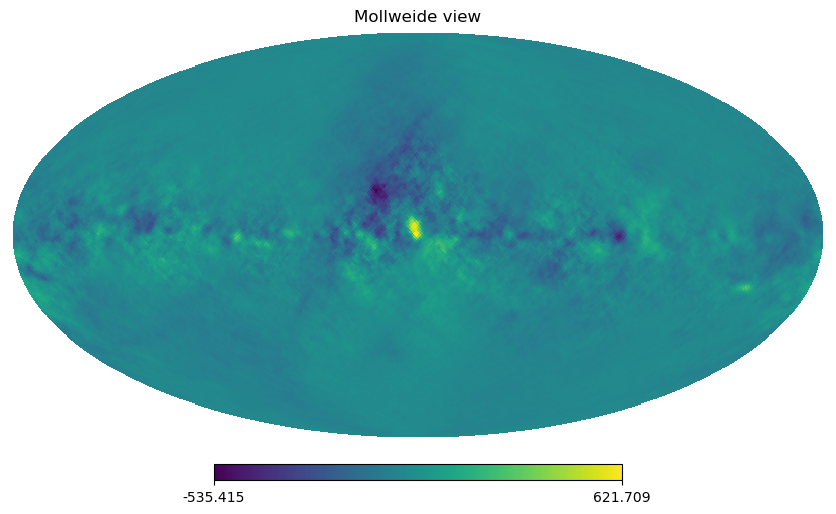

In [10]:
maps_cpnt = np.einsum('cf,fsp->csp', mixing_matrix_sampled.T, freq_maps)

hp.mollview(maps_cpnt[0][0])
hp.mollview(maps_cpnt[0][1])

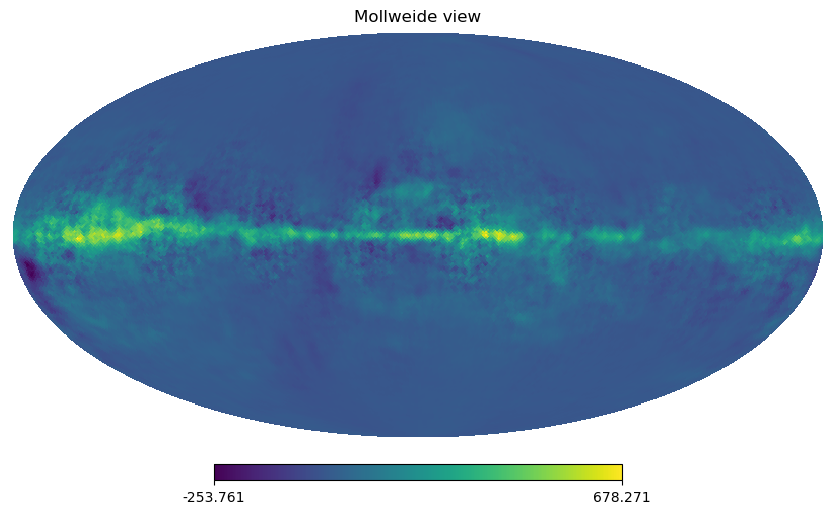

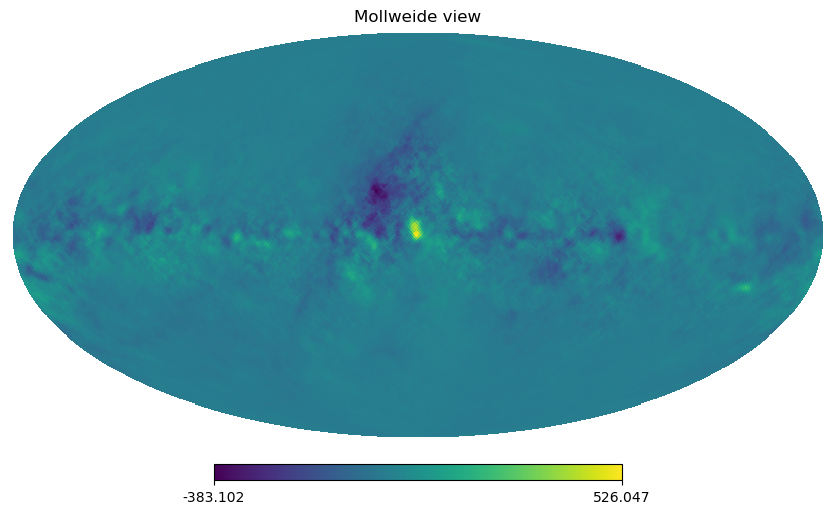

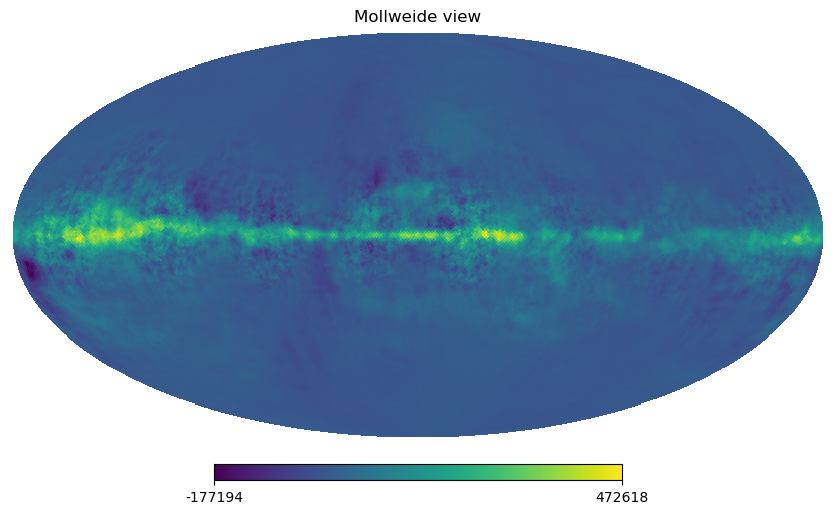

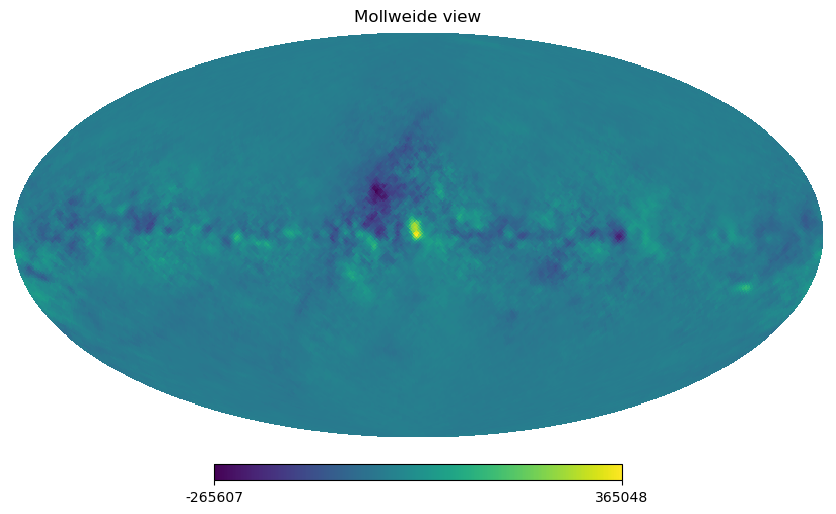

In [11]:
hp.mollview(maps_cpnt[1][0])
hp.mollview(maps_cpnt[1][1])
hp.mollview(maps_cpnt[2][0])
hp.mollview(maps_cpnt[2][1])

## Sampling $\eta$ : $P(\eta | ...) \propto \eta^t (S_{approx} + E^t (B^t N^{-1} B)^{-1} E) \eta$

In [12]:
%%time
eta_maps = np.zeros((nstokes, npix))
map_random_x = []
map_random_y = []
eta_maps = micmac.get_sampling_eta(param_dict, red_cov_approx_matrix, cp_cp_noise, cp_freq_inv_noise_sqrt, map_random_x=map_random_x, map_random_y=map_random_y, initial_guess=np.copy(eta_maps), lmin=lmin, n_iter=n_iter, limit_iter_cg=limit_iter_cg, tolerance=tolerance_CG)
eta_prime_maps = get_sampling_eta_prime(param_dict, red_cov_approx_matrix, cp_cp_noise, cp_freq_inv_noise_sqrt, map_random_x=map_random_x, map_random_y=map_random_y, initial_guess=np.copy(eta_maps), lmin=lmin, n_iter=n_iter, limit_iter_cg=limit_iter_cg, tolerance=tolerance_CG)


Recalculating x !
Recalculating y !
CG-Python eta sampling finished in  0 iterations !!
Recalculating x !
Recalculating y !
CPU times: user 515 ms, sys: 79.9 ms, total: 595 ms
Wall time: 131 ms


## Constrained map realization $s_c$ : $P(s_c | ...) \propto (s_c - s_{c,ML})^t (S_c + E^t (B^t N^{-1} B)^{-1} E)^{-1} (s_c - s_{c,ML})$

In [13]:
s_cML = np.einsum('kc,cf,fsp->ksp', cp_cp_noise, cp_freq_inv_noise, freq_maps)[0,...]

### Fluctuation part

In [14]:
%%time
initial_guess = np.zeros((nstokes,npix))
map_random_realization_xi = np.random.normal(loc=0, scale=1/hp.nside2resol(param_dict["nside"]), size=(param_dict["nstokes"],12*param_dict["nside"]**2))
map_random_realization_chi = np.random.normal(loc=0, scale=1/hp.nside2resol(param_dict["nside"]), size=(param_dict["number_frequencies"],param_dict["nstokes"],12*param_dict["nside"]**2))
fluctuation_maps = micmac.get_fluctuating_term_maps(param_dict, red_cov_matrix, cp_cp_noise, cp_freq_inv_noise_sqrt, map_random_realization_xi=map_random_realization_xi, map_random_realization_chi=map_random_realization_chi, initial_guess=initial_guess, lmin=lmin, n_iter=n_iter, limit_iter_cg=limit_iter_cg, tolerance=tolerance_CG)

CG-Python-0 Fluct finished in  265 iterations !!
CPU times: user 37.3 s, sys: 3.82 s, total: 41.2 s
Wall time: 5.93 s


### Wiener filter part

In [15]:
%%time
initial_guess = np.zeros((nstokes,npix))
wiener_filter_term = micmac.solve_generalized_wiener_filter_term(param_dict, s_cML, red_cov_matrix, cp_cp_noise, initial_guess=initial_guess, lmin=lmin, n_iter=n_iter, limit_iter_cg=limit_iter_cg, tolerance=tolerance_CG)

CG-Python-0 WF finished in  295 iterations !!
CPU times: user 41.9 s, sys: 4.27 s, total: 46.1 s
Wall time: 6.72 s


In [16]:
s_c_map = wiener_filter_term + fluctuation_maps

## Sampling $C$ through inverse Wishart sampling : $P(C | ...) \propto s_c^t C^{-1} s_c + ln|C|$

In [17]:
%%time
c_ells_Wishart = micmac.get_cell_from_map(s_c_map, lmax=lmax, n_iter=n_iter)


CPU times: user 139 ms, sys: 22.6 ms, total: 161 ms
Wall time: 39.2 ms


In [18]:
%%time
red_c_ells_inv_Wishart_sample = np.zeros((lmax+1, nstokes, nstokes))
c_ells_inv_Wishart_sample = np.zeros((number_correlations, lmax+1))

red_c_ells_inv_Wishart_sample = micmac.get_inverse_wishart_sampling_from_c_ells(np.copy(c_ells_Wishart), l_min=lmin)#[lmin:]
c_ells_inv_Wishart_sample = micmac.get_c_ells_from_red_covariance_matrix(red_c_ells_inv_Wishart_sample)

CPU times: user 43.6 ms, sys: 18.9 ms, total: 62.5 ms
Wall time: 13.2 ms


## Few statistics before sampling $\bold{B_f}$ 

## Sampling $\bold{B_f}$ : $P(B_f | ...) \propto -(d - B_c s_c)^t N^{-1} B_f (B_f^t N^{-1} B_f)^{-1} B_f^t N^{-1} (d-B_c s_c) + \eta^t N_c^{1/2} (S_{approx} + E^t (B^T N^{-1} B)^{-1} E) N_c^{1/2} \eta$

In [19]:
s_c_map_extended = np.zeros((number_components, nstokes, npix))
s_c_map_extended[0,...] = s_c_map

full_current_mixing_matrix = mixing_matrix_obj.get_B()

full_data_without_CMB = freq_maps - np.einsum('fc,csp->fsp',full_current_mixing_matrix, s_c_map_extended)

In [20]:
complete_mixing_matrix_fg = mixing_matrix_obj.get_B_fgs()
cp_freq_inv_noise_fg = micmac.get_BtinvN(freq_inverse_noise, complete_mixing_matrix_fg)
cp_cp_noise_fg = micmac.get_inv_BtinvNB(freq_inverse_noise, complete_mixing_matrix_fg)
print(cp_freq_inv_noise_fg, cp_freq_inv_noise_fg.shape, full_data_without_CMB.shape)

map_fgs = np.einsum('cf,fsp->csp', cp_freq_inv_noise_fg, full_data_without_CMB)
print('d-Bcsc -- mean', np.mean(full_data_without_CMB), 'max', np.max(full_data_without_CMB), 'min', np.min(full_data_without_CMB))
print('B_fN^{-1} (d-Bcsc) - mean', np.mean(map_fgs), 'max', np.max(map_fgs), 'min', np.min(map_fgs))
print('B_fN^{-1} - mean', np.mean(cp_freq_inv_noise_fg), 'max', np.max(cp_freq_inv_noise_fg), 'min', np.min(cp_freq_inv_noise_fg))
print('(B_f^t N^{-1} B_f)^{-1} - mean FG', np.mean(cp_cp_noise_fg), 'max', np.max(cp_cp_noise_fg), 'min', np.min(cp_cp_noise_fg))
print('(B_f^t N^{-1} B_f)^{-1} - mean', np.log(np.linalg.det(cp_cp_noise)))

[[0.00000000e+00 4.14656112e-02 1.14055148e+01 1.76728994e+01
  1.68138910e+01 5.91561031e+00]
 [1.23312198e+00 1.05351900e+01 1.10148903e+04 3.48472645e+04
  6.98035817e+04 0.00000000e+00]] (2, 6) (6, 2, 49152)
d-Bcsc -- mean 4.068409407057761 max 555.6914842181119 min -316.0835747554508
B_fN^{-1} (d-Bcsc) - mean 211273.68666581574 max 20087947.476419874 min -11355176.551030327
B_fN^{-1} - mean 9644.112851111144 max 69803.58171339866 min 0.0
(B_f^t N^{-1} B_f)^{-1} - mean FG 0.036555033950238826 max 0.14629657153561887 min -3.82265067544959e-05
(B_f^t N^{-1} B_f)^{-1} - mean -26.14047069478387


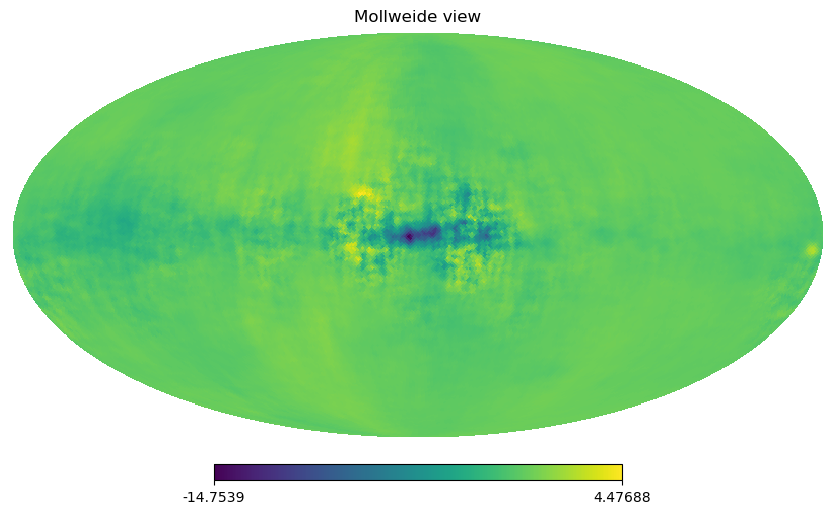

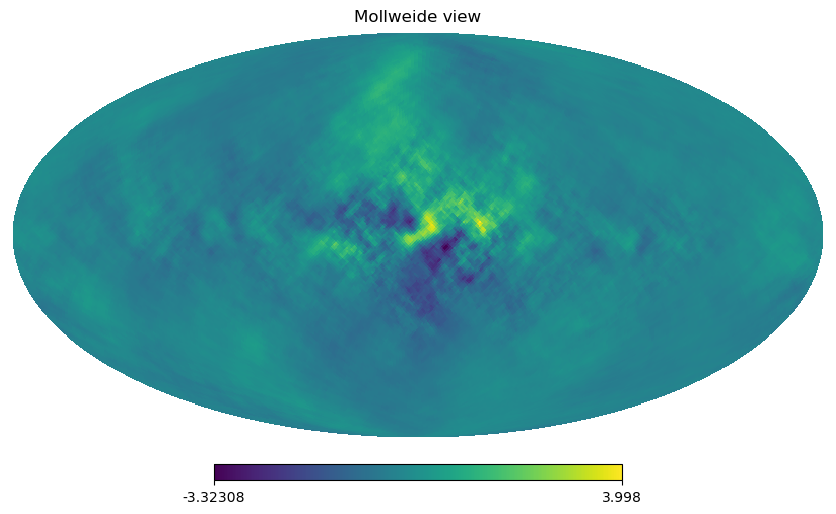

In [21]:
first_residual = input_cmb_maps[0] - np.einsum('kc,cf,fsp->ksp', cp_cp_noise, cp_freq_inv_noise, freq_maps)[0]
hp.mollview(first_residual[0])
hp.mollview(first_residual[1])

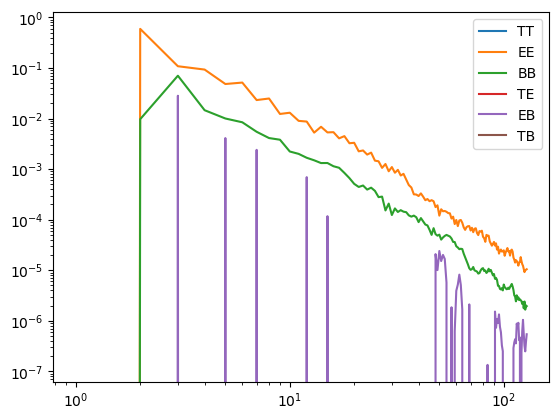

In [22]:
c_ell_first_residual = hp.anafast(np.vstack([np.zeros_like(first_residual[0]),first_residual]), lmax=lmax, iter=n_iter)
ell_arange = np.arange(c_ell_first_residual.shape[1])
plt.plot(ell_arange, c_ell_first_residual.T)
# plt.plot(ell_arange, np.abs(c_ell_first_residual).T)
plt.loglog()
plt.legend(['TT', 'EE', 'BB', 'TE', 'EB', 'TB'])
plt.show()

In [23]:
regularization_constant = -10**(-10)

In [ ]:
@partial(jax.jit, static_argnames=['number_components', 'nstokes', 'nside', 'lmin', 'n_iter', 'limit_iter_cg', 'tolerance', 'with_prints', 'regularization_constant'])
def get_conditional_proba_spectral_likelihood_JAX(complete_mixing_matrix, full_data_without_CMB, eta_prime_maps, freq_inverse_noise, red_cov_approx_matrix, number_components, nstokes, nside, lmin, n_iter, limit_iter_cg, tolerance, with_prints=False, regularization_constant=-10**10):
    """ Get conditional probability of spectral likelihood by sampling it using emcee

        The associated conditional probability is given by : 
        - (d - B_c s_c)^t N^{-1} B_f (B_f^t N^{-1} B_f)^{-1} B_f^t N^{-1} (d - B_c s_c)
    """

    # Building the spectral_likelihood : - (d - B_c s_c)^t N^{-1} B_f (B_f^t N^{-1} B_f)^{-1} B_f^t N^{-1} (d - B_c s_c)
    complete_mixing_matrix_fg = complete_mixing_matrix[:,1:]

    cp_cp_noise_fg = micmac.get_inv_BtinvNB(freq_inverse_noise, complete_mixing_matrix_fg, jax_use=True)
    cp_freq_inv_noise_fg = micmac.get_BtinvN(freq_inverse_noise, complete_mixing_matrix_fg, jax_use=True)

    full_data_without_CMB_with_noise = jnp.einsum('cf,fsp->csp', cp_freq_inv_noise_fg, full_data_without_CMB)
    first_term_complete = jnp.einsum('psc,cm,msp', full_data_without_CMB_with_noise.T, cp_cp_noise_fg, full_data_without_CMB_with_noise)

    return -(-first_term_complete + 0)/2. #+ regularization_constant

def new_get_conditional_proba_spectral_likelihood_JAX(params_mixing_matrix, pos_special_freqs=[-1,0], **model_kwargs):
    new_mixing_matrix = micmac.create_mixing_matrix_jax(params_mixing_matrix, param_dict['number_components'], param_dict['number_frequencies'], pos_special_freqs=pos_special_freqs)
    return get_conditional_proba_spectral_likelihood_JAX(jnp.copy(new_mixing_matrix), jnp.array(full_data_without_CMB), jnp.array(model_kwargs['eta_prime_maps']), freq_inverse_noise, red_cov_approx_matrix, param_dict['number_components'], param_dict['nstokes'], param_dict['nside'], lmin=lmin, n_iter=n_iter, limit_iter_cg=limit_iter_cg, tolerance=tolerance_CG, with_prints=model_kwargs['with_prints'], regularization_constant=regularization_constant)



In [26]:
%%time

# Calculation value log_proba with current value of B_f

# log_proba = micmac.get_conditional_proba_mixing_matrix_foregrounds(mixing_matrix_obj.params, mixing_matrix_obj, full_data_without_CMB, eta_maps, freq_inverse_noise, red_cov_approx_matrix, param_dict, lmin=lmin, n_iter=n_iter, limit_iter_cg=limit_iter_cg, tolerance=tolerance_CG, with_prints=True)
log_proba = new_get_conditional_proba_mixing_matrix_foregrounds_alternative_JAX(mixing_matrix_obj.params, pos_special_freqs=mixing_matrix_obj.pos_special_freqs, full_data_without_CMB=full_data_without_CMB, eta_prime_maps=eta_prime_maps, freq_inverse_noise=freq_inverse_noise, red_cov_approx_matrix=red_cov_approx_matrix, param_dict=param_dict, lmin=lmin, n_iter=n_iter, limit_iter_cg=limit_iter_cg, tolerance=tolerance_CG, with_prints=True, regularization_constant=regularization_constant)
print("Log_proba :", log_proba)
print("<-> Proba :", jnp.exp(log_proba))

CG-Python-0 WF finished in  None iterations !!
Log_proba : 2156273780.904803
<-> Proba : inf
CPU times: user 3.81 s, sys: 394 ms, total: 4.2 s
Wall time: 1.38 s


In [27]:
jitted_new_get_conditional_proba_mixing_matrix_foregrounds_alternative_JAX = jax.jit(new_get_conditional_proba_mixing_matrix_foregrounds_alternative_JAX, static_argnames=['with_prints'])

In [28]:
%%time

# Calculation value log_proba with current value of B_f
log_proba = jitted_new_get_conditional_proba_mixing_matrix_foregrounds_alternative_JAX(mixing_matrix_obj.params, pos_special_freqs=mixing_matrix_obj.pos_special_freqs, full_data_without_CMB=full_data_without_CMB, eta_prime_maps=eta_prime_maps, freq_inverse_noise=freq_inverse_noise, red_cov_approx_matrix=red_cov_approx_matrix, param_dict=param_dict, lmin=lmin, n_iter=n_iter, limit_iter_cg=limit_iter_cg, tolerance=tolerance_CG, with_prints=True, regularization_constant=regularization_constant)
print("Log_proba :", log_proba)
print("<-> Proba :", jnp.exp(log_proba))

Log_proba : 2156273780.904803
<-> Proba : inf
CPU times: user 3.65 s, sys: 465 ms, total: 4.12 s
Wall time: 850 ms


In [29]:
initial_guess_fg_mixing_matrix = mixing_matrix_obj.params.ravel()
dimensions_mixing_matrix = len(initial_guess_fg_mixing_matrix)
full_initial_guess = np.random.uniform(low=initial_guess_fg_mixing_matrix*.95,high=initial_guess_fg_mixing_matrix*1.05, size=(dimensions_mixing_matrix))

In [30]:
with_prints = False

number_steps_sampler = 100
n_walkers = 2

kernel = MetropolisHastings(new_get_conditional_proba_mixing_matrix_foregrounds_alternative_JAX, step_size=0.5)
# kernel = MetropolisHastings(jitted_new_get_conditional_proba_mixing_matrix_foregrounds_alternative_JAX, step_size=0.5)
mcmc = MCMC(kernel, num_chains=n_walkers, num_warmup=0, num_samples=number_steps_sampler)


/var/folders/f8/p6tqlgxj2qn5x_tyjrvc1vnh0000gn/T/ipykernel_86241/392776.py:8: UserWarning: There are not enough devices to run parallel chains: expected 2 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(2)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(kernel, num_chains=n_walkers, num_warmup=0, num_samples=number_steps_sampler)


In [31]:
initial_guess_fg_mixing_matrix = mixing_matrix_obj.params.ravel(order='F')
dimensions_mixing_matrix = len(initial_guess_fg_mixing_matrix)
full_initial_guess = np.random.uniform(low=initial_guess_fg_mixing_matrix*.95,high=initial_guess_fg_mixing_matrix*1.05, size=(n_walkers,dimensions_mixing_matrix))
# full_initial_guess[0] = np.copy(initial_guess_fg_mixing_matrix)
print(mixing_matrix_obj.params, full_initial_guess)

[[1.21055502e-02 3.07566363e+00]
 [5.16775485e-02 4.99076579e+01]
 [1.29207310e-01 2.54769815e+02]
 [4.40790072e-01 1.82995869e+03]] [[1.24770757e-02 5.34139414e-02 1.24500746e-01 4.34763598e-01
  3.11211850e+00 4.99055354e+01 2.54747833e+02 1.82971711e+03]
 [1.22849438e-02 4.96695776e-02 1.24521050e-01 4.39202566e-01
  2.92565138e+00 5.15500586e+01 2.59518152e+02 1.85497189e+03]]


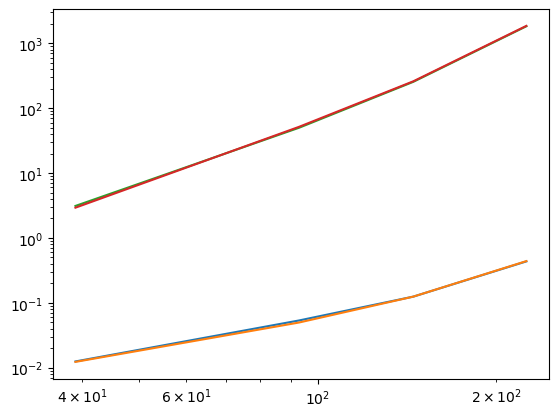

In [32]:
plt.plot(frequency_Bf, full_initial_guess[:,:int(dimensions_mixing_matrix/2)].T, label='init dust pre-sampling')
plt.plot(frequency_Bf, full_initial_guess[:,int(dimensions_mixing_matrix/2):].T, label='init synchrotron pre-sampling')
plt.loglog()
plt.show()

In [33]:
%%time 
mcmc.run(random.PRNGKey(0), init_params=full_initial_guess, full_data_without_CMB=jnp.array(full_data_without_CMB), eta_prime_maps=jnp.array(eta_prime_maps), freq_inverse_noise=jnp.array(freq_inverse_noise), red_cov_approx_matrix=jnp.array(red_cov_approx_matrix), param_dict=param_dict, lmin=lmin, n_iter=n_iter, limit_iter_cg=limit_iter_cg, tolerance=tolerance_CG, with_prints=with_prints)
samples = mcmc.get_samples(group_by_chain=True)
mcmc.print_summary()


sample: 100%|██████████| 100/100 [01:33<00:00,  1.07it/s]


                mean       std    median      5.0%     95.0%     n_eff     r_hat
Param:0[0]     -0.27      0.86     -0.08     -1.76      0.94      6.84      1.42
Param:0[1]     -2.62      1.16     -2.43     -4.45     -1.21      3.93      2.59
Param:0[2]      2.54      1.42      2.25      0.62      4.91      3.58      3.05
Param:0[3]      1.55      1.34      1.61     -0.40      3.59      7.22      1.34
Param:0[4]      2.82      1.00      3.28      1.32      3.83      2.17      1.83
Param:0[5]     47.78      2.36     47.75     44.08     51.50      3.88      2.11
Param:0[6]    254.98      4.22    255.74    247.70    259.79      1.41      3.96
Param:0[7]   1839.35     13.70   1840.70   1820.92   1853.82      1.03     11.96

CPU times: user 19min 25s, sys: 2min 6s, total: 21min 31s
Wall time: 3min 9s


In [34]:
samples.shape

(2, 100, 8)

In [35]:
number_element_column = int(samples.shape[2]/2)
component_dust = samples[:,:,:number_element_column]
component_synchrotron = samples[:,:,number_element_column:]

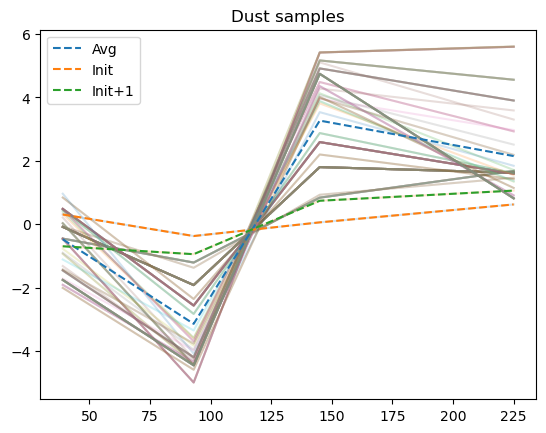

In [41]:
frequency_Bf = instrument['frequency'][1:-1]

plt.plot(frequency_Bf, component_dust[0].T, alpha=0.2)
plt.plot(frequency_Bf, component_dust[0].mean(axis=0), '--', label='Avg')
plt.plot(frequency_Bf, component_dust[0,0,:], '--', label='Init')
plt.plot(frequency_Bf, component_dust[0,1,:], '--', label='Init+1')
# plt.loglog()
plt.title('Dust samples')
plt.legend()
plt.show()

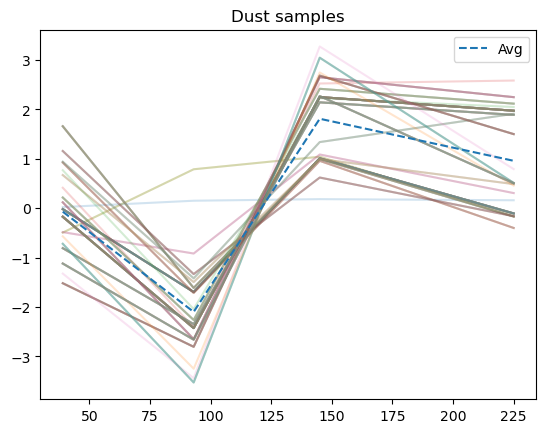

In [37]:
frequency_Bf = instrument['frequency'][1:-1]

plt.plot(frequency_Bf, component_dust[1].T, alpha=0.2)
plt.plot(frequency_Bf, component_dust[1].mean(axis=0), '--', label='Avg')
# plt.loglog()
plt.title('Dust samples')
plt.legend()
plt.show()

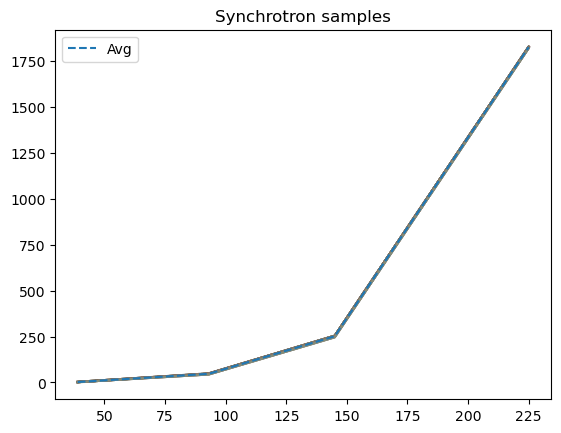

In [38]:
frequency_Bf = instrument['frequency'][1:-1]

plt.plot(frequency_Bf, component_synchrotron[0].T, alpha=0.2)
plt.plot(frequency_Bf, component_synchrotron[0].mean(axis=0), '--', label='Avg')
# plt.loglog()
plt.title('Synchrotron samples')
plt.legend()
plt.show()

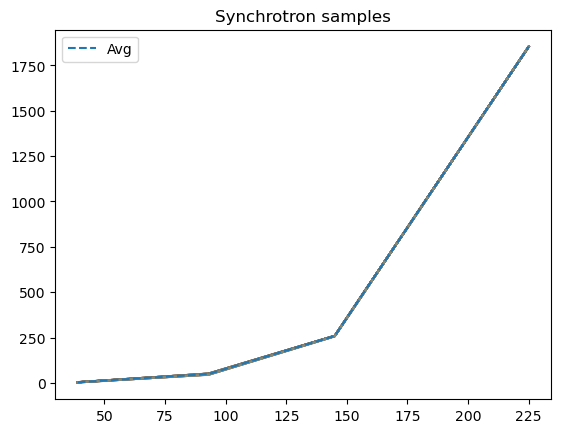

In [39]:
frequency_Bf = instrument['frequency'][1:-1]

plt.plot(frequency_Bf, component_synchrotron[1].T, alpha=0.2)
plt.plot(frequency_Bf, component_synchrotron[1].mean(axis=0), '--', label='Avg')
# plt.loglog()
plt.title('Synchrotron samples')
plt.legend()
plt.show()

In [58]:
samples_chain = mcmc.get_samples(group_by_chain=True)

samples_chain.shape

(2, 100, 8)

In [33]:
# ver = 'J1a'
# filename_backend_mcmc = "validation_numpyro_step_4_SO_{}ver{}".format(nside,ver)
# np.save(filename_backend_mcmc, samples_chain)

ver = 'J0a'
filename_backend_mcmc = "validation_numpyro_step_4_SO_{}ver{}".format(nside,ver)
np.save(filename_backend_mcmc, samples_chain)

In [34]:
chain_samples = mcmc.get_samples(group_by_chain=True)

In [35]:
gelman_rubin_statistic = numpyro.diagnostics.gelman_rubin(chain_samples)
print(gelman_rubin_statistic.shape)
gelman_rubin_statistic

(8,)


array([ 2.37004277,  1.11387337,  4.00558247,  1.08546988,  4.27636892,
        1.00271842,  2.97649006, 13.27488369])

In [ ]:
gelman_rubin_statistic_0 = numpyro.diagnostics.gelman_rubin(np.mean(chain_samples,axis=2))
print(gelman_rubin_statistic_0.shape)
gelman_rubin_statistic_0

()


4.173108189485061

In [ ]:
gelman_rubin_statistic_2 = numpyro.diagnostics.gelman_rubin(chain_samples[:2])
print(gelman_rubin_statistic_2.shape)
gelman_rubin_statistic_2

(8,)


array([1.28471094, 2.42021836, 2.58464444, 2.02191194, 1.07191771,
       3.42065517, 2.39569205, 2.58386433])

In [ ]:
# old_sample = kernel.init(random.PRNGKey(0), init_params=full_initial_guess, full_data_without_CMB=jnp.array(full_data_without_CMB), eta_prime_maps=jnp.array(eta_prime_maps), freq_inverse_noise=jnp.array(freq_inverse_noise), red_cov_approx_matrix=jnp.array(red_cov_approx_matrix), param_dict=param_dict, lmin=lmin, n_iter=n_iter, limit_iter_cg=limit_iter_cg, tolerance=tolerance_CG, with_prints=with_prints)


# all_samples = np.zeros((number_steps_sampler, n_walkers, dimensions_mixing_matrix))

# for iteration in range(number_steps_sampler):
#     new_sample = kernel.sample(old_sample, full_data_without_CMB=jnp.array(full_data_without_CMB), eta_prime_maps=jnp.array(eta_prime_maps), freq_inverse_noise=jnp.array(freq_inverse_noise), red_cov_approx_matrix=jnp.array(red_cov_approx_matrix), param_dict=param_dict, lmin=lmin, n_iter=n_iter, limit_iter_cg=limit_iter_cg, tolerance=tolerance_CG, with_prints=with_prints)

#     old_sample = new_sample


#     # Only check convergence every 100 steps
#     if iteration % 100:
#         continue

#     # Compute the autocorrelation time so far
#     # Using tol=0 means that we'll always get an estimate even
#     # if it isn't trustworthy
#     tau = sample_params_mixing_matrix_FG.get_autocorr_time(tol=0)
#     autocorr[index] = np.mean(tau)
#     index += 1


In [36]:
samples.shape

(2, 1000, 8)

In [ ]:
plt.plot(np.arange(number_steps_sampler), np.abs(samples.mean(axis=(2))).T)
# plt.plot(np.arange(number_steps_sampler), np.abs(samples.mean(axis=(1,2))))
plt.yscale('log')
plt.title(f"SO-{nside}")
plt.xlabel('Number iterations')
plt.ylabel('Mean value of first column of abs(B_f)')
plt.show()

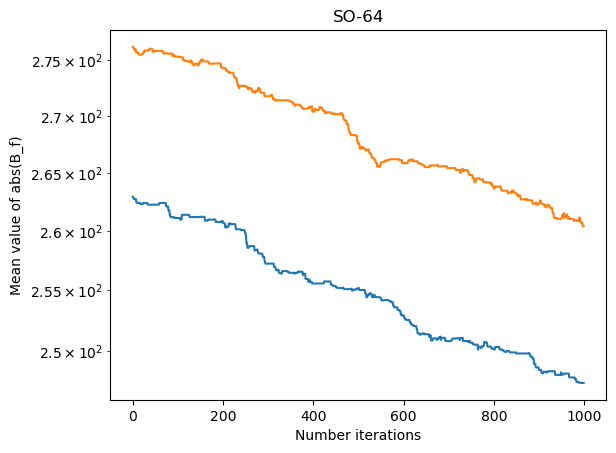

In [38]:
plt.plot(np.arange(number_steps_sampler), np.abs(samples.mean(axis=(2))).T)
# plt.plot(np.arange(number_steps_sampler), np.abs(samples.mean(axis=(1,2))))
plt.yscale('log')
plt.title(f"SO-{nside}")
plt.xlabel('Number iterations')
plt.ylabel('Mean value of abs(B_f)')
plt.show()

In [ ]:
autocorrelation = numpyro.diagnostics.autocorrelation(samples)
autocovariance = numpyro.diagnostics.autocovariance(samples)



In [ ]:
autocorrelation.shape

(700, 1, 8)

In [ ]:
autocovariance.shape

(700, 1, 8)

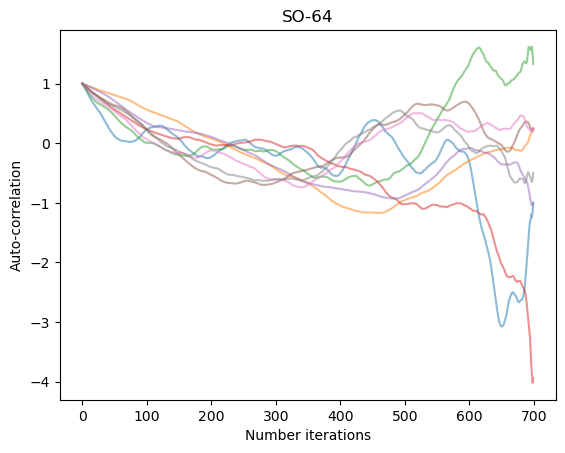

In [ ]:

plt.plot(np.arange(number_steps_sampler), autocorrelation[:,0,:], alpha=.5)
# plt.plot(np.arange(number_steps_sampler), np.mean(autocorrelation[:,0,:],axis=1), 'k')
# plt.loglog()
plt.title(f"SO-{nside}")
plt.xlabel('Number iterations')
plt.ylabel('Auto-correlation')
plt.show()

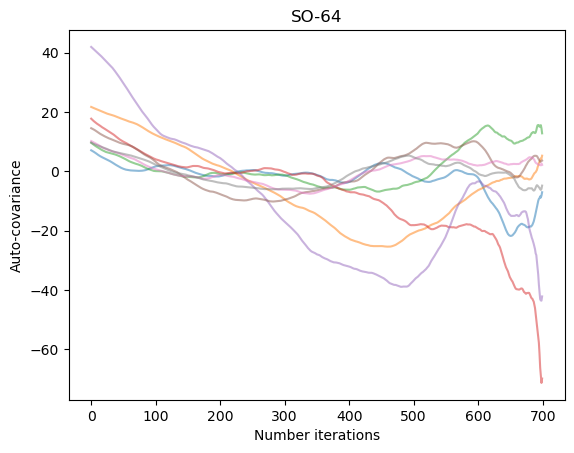

In [ ]:

plt.plot(np.arange(number_steps_sampler), autocovariance[:,0,:], alpha=.5)
# plt.plot(np.arange(number_steps_sampler), np.mean(autocorrelation[:,0,:],axis=1), 'k')
# plt.loglog()
plt.title(f"SO-{nside}")
plt.xlabel('Number iterations')
plt.ylabel('Auto-covariance')
plt.show()

In [ ]:
autocorrelation_times = np.array([1 + 2*(autocorrelation[i*100:(i+1)*100]/autocorrelation[i*100]).sum(axis=0) for i in range(7)])

In [ ]:
autocorrelation_times

array([[[   63.79095859,   161.09999382,    92.57021867,   118.28840687,
           140.00609   ,   127.25284414,   106.32375782,   124.70962088]],

       [[   36.13165418,   117.98385449, -3269.36898061,    88.14224889,
           128.78817579,  -166.22666612,  -386.79518031,  -109.06069047]],

       [[   57.40231003,  -417.4126455 ,   200.64159748,   -49.771898  ,
          -237.7484772 ,   245.3334249 ,   576.9414696 ,   277.548081  ]],

       [[  252.02666278,   327.10426618,   687.17852401,  2473.33222267,
           311.9451764 ,   135.31273953,   197.66334663,   169.83234917]],

       [[  -22.84121669,   213.27659937,   183.99638445,   331.68981548,
           224.29592965,  -114.16293229,   -55.83473957,  -462.63759895]],

       [[  192.70499288,   140.01772333,  -195.44609265,   204.70822879,
           111.9853972 ,   258.79124916,   194.04872554,    98.90293358]],

       [[ 1272.21949916,    78.94380689,   192.86804936,   358.05416182,
           835.13471414,    55.03

In [ ]:
import emcee.autocorr

In [ ]:
# https://github.com/dfm/emcee/blob/59b6a34323022bc547c3a9fb2173cbffe806af9b/src/emcee/backends/backend.py#L130
emcee.autocorr.integrated_time(samples, tol=0)

array([59.53177363, 85.31270358, 57.24913837, 91.02485449, 81.28128676,
       48.91212108, 53.95907357, 52.25562043])

In [ ]:
# %%time


# # And now sampling B_f using emcee

# n_walkers = 20
# # We have 6*3 parameters to sample, trying to go with 100 steps first
# # number_steps_sampler = 1000
# number_steps_sampler = 700
# with_prints = False

# # whole_chain_samples = micmac.sample_mixing_matrix_term(param_dict, mixing_matrix_obj, full_data_without_CMB, eta_prime_maps, red_cov_approx_matrix, freq_inverse_noise, lmin=lmin, n_iter=n_iter, limit_iter_cg=limit_iter_cg, tolerance=10**(-12), n_walkers=n_walkers, number_steps_sampler=number_steps_sampler, with_prints=with_prints)

# initial_guess_fg_mixing_matrix = mixing_matrix_obj.params.ravel()
# dimensions_mixing_matrix = len(initial_guess_fg_mixing_matrix)

# backend = emcee.backends.HDFBackend(filename_backend_mcmc)
# backend.reset(n_walkers, dimensions_mixing_matrix) # To reset the file !

# # sample_params_mixing_matrix_FG = emcee.EnsembleSampler(n_walkers, dimensions_mixing_matrix, get_conditional_proba_mixing_matrix_foregrounds, args=[mixingmatrix_object, full_data_without_CMB, eta_maps, freq_inverse_noise, red_cov_approx_matrix, param_dict, lmin, n_iter, limit_iter_cg, tolerance, with_prints])
# sample_params_mixing_matrix_FG = emcee.EnsembleSampler(n_walkers, dimensions_mixing_matrix, get_conditional_proba_mixing_matrix_foregrounds, args=[mixing_matrix_obj, full_data_without_CMB, eta_prime_maps, freq_inverse_noise, red_cov_approx_matrix, param_dict, lmin, n_iter, limit_iter_cg, tolerance_CG, with_prints], backend=backend)

# # We'll track how the average autocorrelation time estimate changes
# index = 0
# autocorr = np.empty(number_steps_sampler)

# # This will be useful to testing convergence
# old_tau = np.inf

# # Initial guess
# # full_initial_guess = np.random.randn(n_walkers,dimensions_mixing_matrix)
# full_initial_guess = np.random.uniform(low=initial_guess_fg_mixing_matrix*.05,high=initial_guess_fg_mixing_matrix*1.05, size=(n_walkers,dimensions_mixing_matrix))
# full_initial_guess[0] = np.copy(initial_guess_fg_mixing_matrix)

# # final_position_walkers = sample_params_mixing_matrix_FG.run_mcmc(full_initial_guess, number_steps_sampler)

# # Now we'll sample for up to number_steps_sampler steps
# for sample in sample_params_mixing_matrix_FG.sample(full_initial_guess, iterations=number_steps_sampler, progress=True):
#     # Only check convergence every 100 steps
#     if sample_params_mixing_matrix_FG.iteration % 100:
#         continue

#     # Compute the autocorrelation time so far
#     # Using tol=0 means that we'll always get an estimate even
#     # if it isn't trustworthy
#     tau = sample_params_mixing_matrix_FG.get_autocorr_time(tol=0)
#     autocorr[index] = np.mean(tau)
#     index += 1

#     # Check convergence
#     converged = np.all(tau * 100 < sample_params_mixing_matrix_FG.iteration)
#     converged &= np.all(np.abs(old_tau - tau) / tau < 0.01)
#     if converged:
#         break
#     old_tau = tau


In [ ]:
mixing_matrix_sampled = last_sample

In [ ]:
cp_cp_noise = micmac.get_inv_BtinvNB(freq_inverse_noise, mixing_matrix_sampled)
cp_freq_inv_noise_sqrt = micmac.get_BtinvN(scipy.linalg.sqrtm(freq_inverse_noise), mixing_matrix_sampled)
cp_freq_inv_noise = micmac.get_BtinvN(freq_inverse_noise, mixing_matrix_sampled)

residual_post_sampling = input_cmb_maps[0] - np.einsum('kc,cf,fsp->ksp', cp_cp_noise, cp_freq_inv_noise, freq_maps)[0]

In [ ]:
hp.mollview(residual_post_sampling[0][0])
hp.mollview(residual_post_sampling[0][1])

## Sample study

In [ ]:
ell_arange = np.arange(c_ells_input.shape[1])

In [ ]:
number_correl_to_plot = int(np.ceil(nstokes**2/2) + np.floor(nstokes/2))

if nstokes == 3:
    number_subplots_convention = 421
    figsize = (10,10)
    figsize_big = (12,12)
    position_legend = int(number_correl_to_plot/2)-1
    bbox_to_anchor=(2.2, 1)
elif nstokes == 2:
    number_subplots_convention = 131
    figsize = (14,6)
    figsize_big = figsize
    position_legend = number_correl_to_plot-2
    bbox_to_anchor=(1, 1)
else:
    number_subplots_convention = 111
    figsize = (10,10)
    figsize_big = (10,10)
    position_legend = int(number_correl_to_plot/2)-1
    bbox_to_anchor=(2.2, 1)